<a href="https://colab.research.google.com/github/adityaraghavan98/Reinforcement-learning-Course-ECE517-/blob/main/Aditya_RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating Ferroelectric Domain Discovery via Reinforcement Learning

Notebook made by Aditya Raghavan

Reinforcement learning Course (ECE517) final project

In [ ]:
!pip -q install "stable-baselines3>=2.3.0" "gymnasium>=0.29.1" matplotlib numpy pandas


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

SEED = 7
np.random.seed(SEED)


In [ ]:
def synthetic_loop(voltage_cycle, P_s, E_c, w, noise=0.0, rng=None):
    """
    Ferroelectric-like hysteresis loop.
    voltage_cycle: -Vmax -> +Vmax -> -Vmax (one full cycle)
    Up branch:   P_up   = P_s * tanh((E - E_c)/w)
    Down branch: P_down = P_s * tanh((E + E_c)/w)
    """
    v = np.asarray(voltage_cycle)
    n = len(v)
    half = n // 2

    v_up   = v[:half]
    v_down = v[half:]

    P_up   = P_s * np.tanh((v_up   - E_c) / w)
    P_down = P_s * np.tanh((v_down + E_c) / w)

    P = np.concatenate([P_up, P_down])

    if noise > 0.0 and rng is not None:
        P = P + noise * rng.standard_normal(P.shape)

    return P


def loop_area_trapz(voltage_cycle, signal):
    """
    Closed-loop area over one full cycle, integrating |P(E)| dE.
    Larger area ≈ stronger hysteresis.
    """
    v = np.asarray(voltage_cycle)
    s = np.asarray(signal)
    return float(np.trapz(np.abs(s), v))


In [ ]:
class SpectroScanEnv(gym.Env):
    """
    2D grid of pixels. Each pixel has a hidden hysteresis loop and loop AREA.

    Agent moves:
      Actions: 0 up, 1 down, 2 left, 3 right, 4 stay

    Reward:
      r_t = norm_area - move_cost - revisit_penalty
            + discovery_bonus * 1{ first visit to a HIGH-area pixel }

    Observation:
      [x_norm, y_norm, last_area_norm, steps_left_norm, visited_fraction]
    """
    metadata = {"render_modes": ["rgb_array"]}

    def __init__(
        self,
        grid_size=64,
        n_blobs=3,
        max_steps=400,
        move_cost=0.01,
        revisit_penalty=0.02,
        discovery_bonus=1.0,      # bonus for discovering NEW high pixel
        high_quantile=0.9,        # top 10% pixels treated as "high loop area"
        voltage_span=10.0,
        n_volt=201,
        seed=0,
        render_mode=None,
        start_mode="corner"
    ):
        super().__init__()
        self.gs = grid_size
        self.n_blobs = n_blobs
        self.max_steps = max_steps
        self.move_cost = move_cost
        self.revisit_penalty = revisit_penalty
        self.discovery_bonus = discovery_bonus
        self.high_quantile = high_quantile
        self.render_mode = render_mode
        self.start_mode = start_mode

        self.rng = np.random.default_rng(seed)

        # Actions: 0 up, 1 down, 2 left, 3 right, 4 stay
        self.action_space = spaces.Discrete(5)

        # Observations
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(5,), dtype=np.float32
        )

        # Parameter maps (weak background + strong blobs)
        self.Ps_map, self.Ec_map, self.w_map = self._make_param_maps()

        # Voltage cycle: -V -> +V -> -V
        half_n = n_volt // 2
        v_up   = np.linspace(-voltage_span, voltage_span, half_n, endpoint=True)
        v_down = np.linspace(voltage_span, -voltage_span, n_volt - half_n, endpoint=True)
        self.voltage_cycle = np.concatenate([v_up, v_down])

        # Precompute loop areas
        self.area_map = self._precompute_area_map()

        # Normalization
        self.area_min = float(self.area_map.min())
        self.area_max = float(self.area_map.max())
        self.area_rng = max(1e-8, self.area_max - self.area_min)

        # Define "high-area" pixels and tracking mask
        thr = np.quantile(self.area_map, self.high_quantile)
        self.high_mask = self.area_map >= thr
        self.high_total = int(self.high_mask.sum())

        # State
        self.y = self.x = self.t = 0
        self.visited = np.zeros((self.gs, self.gs), dtype=bool)
        self.last_area_norm = 0.0
        self.high_visited = np.zeros((self.gs, self.gs), dtype=bool)

    def _make_param_maps(self):
        """
        Make a smooth background with weak loops and a few very strong blobs
        (high Ps) to create clear high-area regions.
        """
        H = W = self.gs
        yy, xx = np.mgrid[0:H, 0:W]
        yy = yy / (H - 1)
        xx = xx / (W - 1)

        # Weak uniform background
        Ps = np.full((H, W), 0.3, dtype=np.float32)
        Ec = np.full((H, W), 2.0, dtype=np.float32)
        w  = np.full((H, W), 0.8, dtype=np.float32)

        # Strong blobs with large Ps
        for _ in range(self.n_blobs):
            cx, cy = self.rng.uniform(0.2, 0.8, size=2)
            sx, sy = self.rng.uniform(0.06, 0.12, size=2)

            ampPs = self.rng.uniform(2.0, 4.0)  # strong saturation
            gauss = np.exp(-(((xx - cx)**2)/(2*sx**2) + ((yy - cy)**2)/(2*sy**2)))
            Ps += ampPs * gauss

        return Ps, Ec, w

    def _precompute_area_map(self):
        H = W = self.gs
        areas = np.zeros((H, W), dtype=np.float32)
        for i in range(H):
            for j in range(W):
                Psij = float(self.Ps_map[i, j])
                Ecij = float(self.Ec_map[i, j])
                wij  = float(self.w_map[i, j])
                loop = synthetic_loop(
                    self.voltage_cycle, Psij, Ecij, wij,
                    noise=0.0, rng=self.rng
                )
                areas[i, j] = loop_area_trapz(self.voltage_cycle, loop)
        return areas

    def _norm_area(self, area):
        return (area - self.area_min) / self.area_rng

    def _obs(self):
        x_norm = self.x / (self.gs - 1)
        y_norm = self.y / (self.gs - 1)
        steps_left_norm  = (self.max_steps - self.t) / self.max_steps
        visited_fraction = self.visited.sum() / (self.gs * self.gs)
        return np.array(
            [x_norm, y_norm, self.last_area_norm, steps_left_norm, visited_fraction],
            dtype=np.float32,
        )

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.t = 0
        if self.start_mode == "corner":
            corners = [(0,0), (0,self.gs-1), (self.gs-1,0), (self.gs-1,self.gs-1)]
            self.y, self.x = corners[self.rng.integers(0, 4)]
        else:
            self.y = int(self.rng.integers(0, self.gs))
            self.x = int(self.rng.integers(0, self.gs))

        self.visited.fill(False)
        self.high_visited.fill(False)

        self.visited[self.y, self.x] = True
        area = self.area_map[self.y, self.x]
        self.last_area_norm = self._norm_area(area)
        if self.high_mask[self.y, self.x]:
            self.high_visited[self.y, self.x] = True

        return self._obs(), {}

    def step(self, action):
        # Move
        if action == 0 and self.y > 0:                 # up
            self.y -= 1
        elif action == 1 and self.y < self.gs - 1:     # down
            self.y += 1
        elif action == 2 and self.x > 0:               # left
            self.x -= 1
        elif action == 3 and self.x < self.gs - 1:     # right
            self.x += 1
        # 4 = stay

        self.t += 1

        area      = self.area_map[self.y, self.x]
        area_norm = self._norm_area(area)

        move_pen    = self.move_cost * (action != 4)
        revisit_pen = self.revisit_penalty if self.visited[self.y, self.x] else 0.0

        # Discovery bonus if this is first visit to a high-area pixel
        discovery = 0.0
        if self.high_mask[self.y, self.x] and not self.high_visited[self.y, self.x]:
            discovery = self.discovery_bonus
            self.high_visited[self.y, self.x] = True

        reward = float(area_norm) - float(move_pen) - float(revisit_pen) + float(discovery)

        self.visited[self.y, self.x] = True
        self.last_area_norm = area_norm

        terminated = False
        truncated  = self.t >= self.max_steps

        info = {
            "area": area,
            "area_norm": area_norm,
            "pos": (self.y, self.x),
            "high_found": int(self.high_visited.sum()),
            "high_total": int(self.high_total),
        }
        return self._obs(), reward, terminated, truncated, info

    def render(self):
        img = (self.area_map - self.area_min) / self.area_rng
        rgb = np.stack([img, img, img], axis=-1)
        rgb = np.clip(rgb, 0, 1)
        rgb[self.y, self.x] = np.array([1.0, 0.0, 0.0])
        return (rgb * 255).astype(np.uint8)


In [ ]:
log_dir = "./spectro_logs_all_blobs"
os.makedirs(log_dir, exist_ok=True)

def make_train_env():
    env = SpectroScanEnv(
        grid_size=64, n_blobs=4, max_steps=400,
        move_cost=0.01, revisit_penalty=0.02,
        discovery_bonus=1.0, high_quantile=0.9,
        voltage_span=10.0, n_volt=201,
        seed=SEED, start_mode="corner"
    )
    return Monitor(env)  # monitor for reward logging if you want

train_env = make_vec_env(make_train_env, n_envs=1, seed=SEED)

model = PPO(
    "MlpPolicy",
    train_env,
    n_steps=2048,
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    learning_rate=3e-4,
    ent_coef=0.01,
    clip_range=0.2,
    seed=SEED,
    verbose=1,
)

total_timesteps = 150_000   # lower (e.g. 80_000) if training feels slow
model.learn(total_timesteps=total_timesteps)


/tmp/ipython-input-3398967644.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(np.abs(s), v))


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -2.32    |
| time/              |          |
|    fps             | 1215     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 8.06       |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00957423 |
|    clip_fraction        | 0.084      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.6       |
|    explained_variance   | 0.0326     |
|    learning_rate        | 

In [ ]:
def rollout_with_coverage(env, policy_fn, episodes=5):
    """
    Returns:
      returns: episode returns
      best_areas: best area value seen in episode
      coverages: fraction of high-area pixels discovered
    """
    returns, best_areas, coverages, trajs = [], [], [], []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = trunc = False
        total = 0.0
        best_area = 0.0
        path = []
        high_found = 0
        high_total = env.high_total
        while not (done or trunc):
            a = policy_fn(obs)
            obs, r, done, trunc, info = env.step(a)
            total += r
            path.append(info["pos"])
            best_area = max(best_area, info["area"])
            high_found = info["high_found"]
        returns.append(total)
        best_areas.append(best_area)
        trajs.append(path)
        coverages.append(high_found / max(1, high_total))
    return np.array(returns), np.array(best_areas), np.array(coverages), trajs


def random_policy(_obs):
    return np.random.randint(0, 5)


def raster_policy_factory(grid_size):
    # row-wise lawnmower
    waypoints = []
    for r in range(grid_size):
        cols = range(grid_size) if r % 2 == 0 else range(grid_size-1, -1, -1)
        for c in cols:
            waypoints.append((r, c))
    idx = {"i": 0}

    def policy(obs):
        x_norm, y_norm = float(obs[0]), float(obs[1])
        x = int(round(x_norm * (grid_size - 1)))
        y = int(round(y_norm * (grid_size - 1)))
        i = idx["i"]
        if i >= len(waypoints):
            return 4  # stay
        target = waypoints[i]
        if (y, x) == target:
            idx["i"] += 1
            return 4
        if target[0] < y: return 0
        if target[0] > y: return 1
        if target[1] < x: return 2
        if target[1] > x: return 3
        return 4

    return policy


In [ ]:
# Same map in all envs (same seed & params)
eval_kwargs = dict(
    grid_size=64, n_blobs=4, max_steps=400,
    move_cost=0.01, revisit_penalty=0.02,
    discovery_bonus=1.0, high_quantile=0.9,
    voltage_span=10.0, n_volt=201,
    seed=SEED, start_mode="corner"
)

env_rand = SpectroScanEnv(**eval_kwargs)
env_ras  = SpectroScanEnv(**eval_kwargs)
env_ppo  = SpectroScanEnv(**eval_kwargs)

def rand_pi(obs): return np.random.randint(0, 5)

ras_pi = raster_policy_factory(env_ras.gs)

def ppo_pi(obs):
    a, _ = model.predict(obs, deterministic=True)
    return int(a)

ret_rnd, best_rnd, cov_rnd, traj_rnd = rollout_with_coverage(env_rand, rand_pi, episodes=10)
ret_ras, best_ras, cov_ras, traj_ras = rollout_with_coverage(env_ras, ras_pi,  episodes=10)
ret_ppo, best_ppo, cov_ppo, traj_ppo = rollout_with_coverage(env_ppo, ppo_pi,  episodes=10)

print(f"Mean return    — Random: {ret_rnd.mean():.3f} | Raster: {ret_ras.mean():.3f} | PPO: {ret_ppo.mean():.3f}")
print(f"Mean coverage  — Random: {cov_rnd.mean():.3f} | Raster: {cov_ras.mean():.3f} | PPO: {cov_ppo.mean():.3f}")
print(f"Mean best area — Random: {best_rnd.mean():.3f} | Raster: {best_ras.mean():.3f} | PPO: {best_ppo.mean():.3f}")


/tmp/ipython-input-3398967644.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(np.abs(s), v))


Mean return    — Random: 5.387 | Raster: 49.479 | PPO: 329.013
Mean coverage  — Random: 0.008 | Raster: 0.035 | PPO: 0.044
Mean best area — Random: 0.014 | Raster: 0.033 | PPO: 0.076


/tmp/ipython-input-3398967644.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(np.abs(s), v))


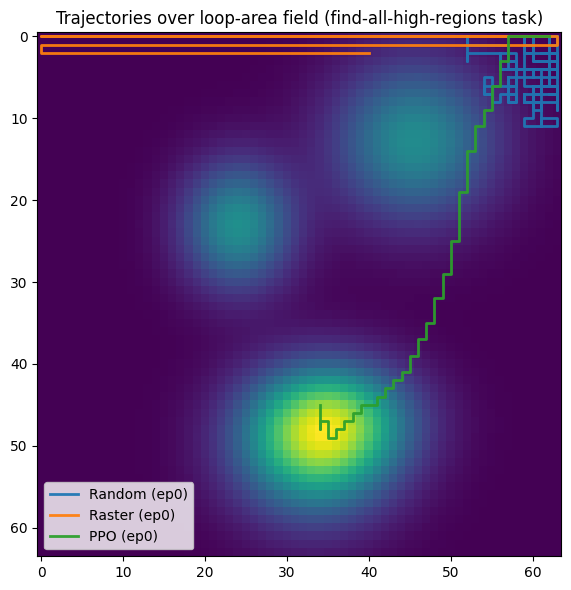

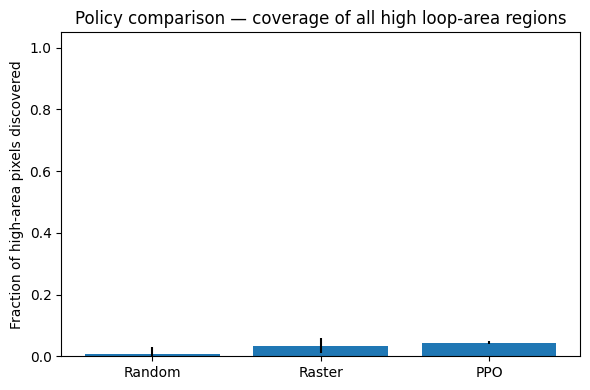

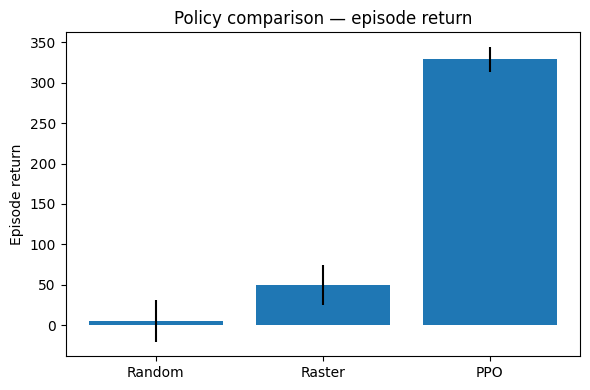

In [ ]:
def plot_trajectories(area_map, trajs_dict, title="Trajectories over loop-area field"):
    plt.figure(figsize=(6,6))
    plt.imshow(area_map, origin="upper")
    for name, traj in trajs_dict.items():
        ys = [p[0] for p in traj]
        xs = [p[1] for p in traj]
        plt.plot(xs, ys, label=name, linewidth=2, alpha=0.95)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Reveal the map once
viz_env = SpectroScanEnv(**eval_kwargs)
area_map = viz_env.area_map

plot_trajectories(
    area_map,
    {
        "Random (ep0)": traj_rnd[0],
        "Raster (ep0)": traj_ras[0],
        "PPO (ep0)":    traj_ppo[0],
    },
    title="Trajectories over loop-area field (find-all-high-regions task)"
)

labels = ["Random", "Raster", "PPO"]

# Coverage bar plot
means_cov = [cov_rnd.mean(), cov_ras.mean(), cov_ppo.mean()]
stds_cov  = [cov_rnd.std(),  cov_ras.std(),  cov_ppo.std()]

plt.figure(figsize=(6,4))
plt.bar(labels, means_cov, yerr=stds_cov)
plt.ylim(0, 1.05)
plt.ylabel("Fraction of high-area pixels discovered")
plt.title("Policy comparison — coverage of all high loop-area regions")
plt.tight_layout()
plt.show()

# Episode return bar plot (optional)
means_ret = [ret_rnd.mean(), ret_ras.mean(), ret_ppo.mean()]
stds_ret  = [ret_rnd.std(),  ret_ras.std(),  ret_ppo.std()]

plt.figure(figsize=(6,4))
plt.bar(labels, means_ret, yerr=stds_ret)
plt.ylabel("Episode return")
plt.title("Policy comparison — episode return")
plt.tight_layout()
plt.show()


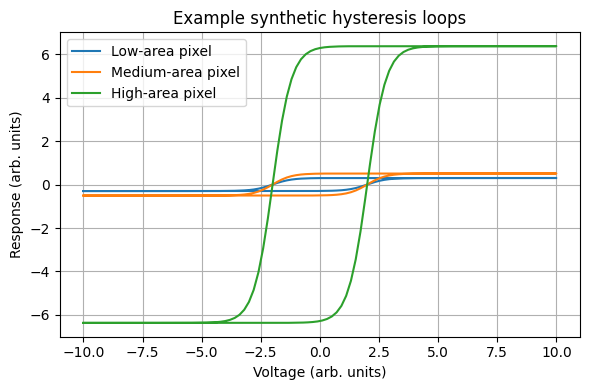

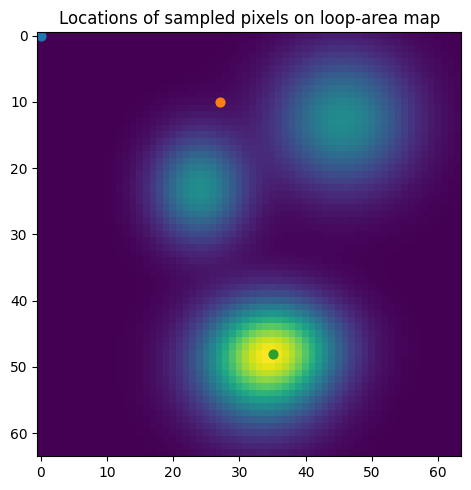

In [ ]:
flat = area_map.flatten()
idx_min  = flat.argmin()
idx_max  = flat.argmax()
idx_mid  = np.argsort(flat)[len(flat)//2]

coords = []
for idx in [idx_min, idx_mid, idx_max]:
    y = idx // viz_env.gs
    x = idx %  viz_env.gs
    coords.append((y, x))

labels_pts = ["Low-area pixel", "Medium-area pixel", "High-area pixel"]

plt.figure(figsize=(6,4))
for (y, x), lab in zip(coords, labels_pts):
    Ps = float(viz_env.Ps_map[y, x])
    Ec = float(viz_env.Ec_map[y, x])
    w  = float(viz_env.w_map[y, x])
    loop = synthetic_loop(viz_env.voltage_cycle, Ps, Ec, w, noise=0.0, rng=viz_env.rng)
    plt.plot(viz_env.voltage_cycle, loop, label=f"{lab}")

plt.xlabel("Voltage (arb. units)")
plt.ylabel("Response (arb. units)")
plt.title("Example synthetic hysteresis loops")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(area_map, origin="upper")
for (y, x), lab in zip(coords, labels_pts):
    plt.scatter([x], [y], s=40, label=lab)
# plt.legend()
plt.title("Locations of sampled pixels on loop-area map")
plt.tight_layout()
plt.show()


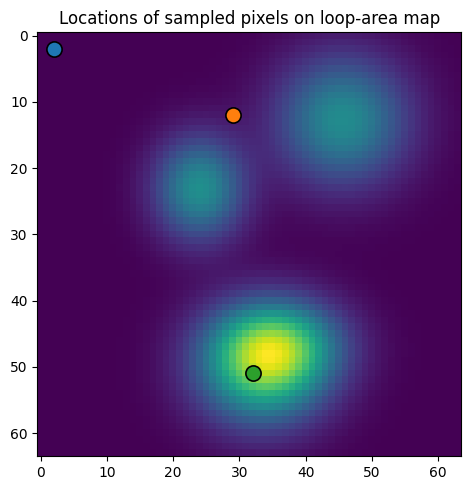

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(area_map, origin="upper")

offsets = [(2, 2), (2, 2), (3, -3)]  # tweak as needed

for (y, x), lab, (dy, dx) in zip(coords, labels_pts, offsets):
    plt.scatter([x+dx], [y+dy], s=120, edgecolor="black", linewidth=1.2,
                label=lab, zorder=3)
    # plt.text(x+dx+1, y+dy+1, lab, color="white",
    #          fontsize=10, weight="bold", zorder=4)

plt.title("Locations of sampled pixels on loop-area map")
plt.tight_layout()
plt.show()


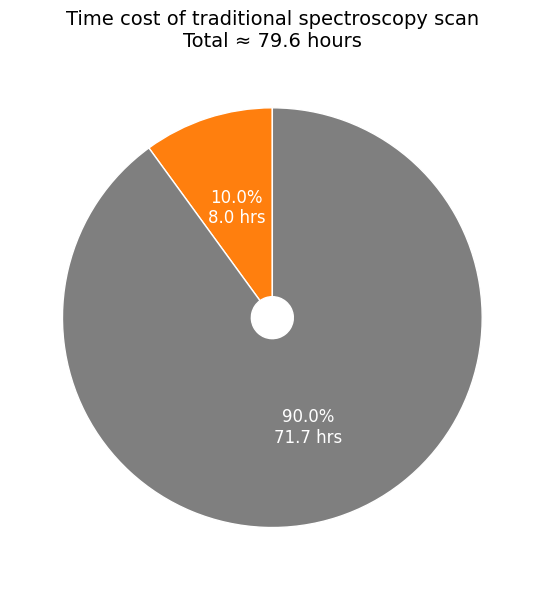

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1) Compute actual sparsity from area_map
# -------------------------
flat = area_map.flatten()
thr = np.quantile(flat, 0.9)

high_pixels = (flat >= thr).sum()
total_pixels = len(flat)
low_pixels = total_pixels - high_pixels

frac_high = high_pixels / total_pixels
frac_low  = low_pixels  / total_pixels

# -------------------------
# 2) Time cost
# -------------------------
t_spec = 30
t_move = 40
t_per_pixel = t_spec + t_move

time_high_hr = (high_pixels * t_per_pixel) / 3600
time_low_hr  = (low_pixels  * t_per_pixel) / 3600
total_time_hr = time_high_hr + time_low_hr

# -------------------------
# 3) Pie chart with both % and time INSIDE slices
# -------------------------
sizes = [high_pixels, low_pixels]
colors = ["tab:orange", "tab:gray"]

fig, ax = plt.subplots(figsize=(6, 6))

wedges, texts = ax.pie(
    sizes,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.9, edgecolor='white')
)

# Add inside-slice labels manually
kw = dict(va="center", ha="center", fontsize=12, color="white")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    x = 0.55 * np.cos(np.deg2rad(ang))
    y = 0.55 * np.sin(np.deg2rad(ang))

    if i == 0:   # useful region
        label = f"{frac_high*100:.1f}%\n{time_high_hr:.1f} hrs"
    else:        # wasted region
        label = f"{frac_low*100:.1f}%\n{time_low_hr:.1f} hrs"

    ax.text(x, y, label, **kw)

plt.title(
    f"Time cost of traditional spectroscopy scan\nTotal ≈ {total_time_hr:.1f} hours",
    fontsize=14
)

plt.tight_layout()
plt.savefig("time_cost_pie_inside.png", dpi=300)
plt.show()


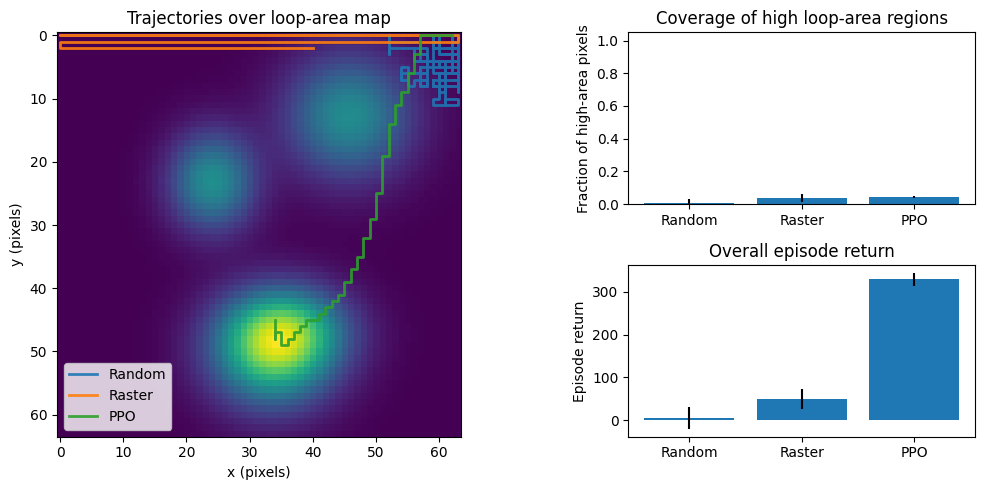

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Random", "Raster", "PPO"]

means_cov = [cov_rnd.mean(), cov_ras.mean(), cov_ppo.mean()]
stds_cov  = [cov_rnd.std(),  cov_ras.std(),  cov_ppo.std()]

means_ret = [ret_rnd.mean(), ret_ras.mean(), ret_ppo.mean()]
stds_ret  = [ret_rnd.std(),  ret_ras.std(),  ret_ppo.std()]

# ---- Combined figure ----
fig = plt.figure(figsize=(11, 5))

# 1) Trajectories (left, large)
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
im = ax1.imshow(area_map, origin="upper", cmap="viridis")
for name, traj, color in [
    ("Random", traj_rnd[0], "tab:blue"),
    ("Raster", traj_ras[0], "tab:orange"),
    ("PPO",    traj_ppo[0], "tab:green"),
]:
    ys = [p[0] for p in traj]
    xs = [p[1] for p in traj]
    ax1.plot(xs, ys, label=name, linewidth=2, alpha=0.9, color=color)

ax1.set_title("Trajectories over loop-area map")
ax1.set_xlabel("x (pixels)")
ax1.set_ylabel("y (pixels)")
ax1.legend(loc="lower left", frameon=True)

# 2) Coverage bar plot (top-right)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.bar(labels, means_cov, yerr=stds_cov)
ax2.set_ylim(0, 1.05)
ax2.set_ylabel("Fraction of high-area pixels")
ax2.set_title("Coverage of high loop-area regions")

# 3) Return bar plot (bottom-right)
ax3 = plt.subplot2grid((2, 3), (1, 2))
ax3.bar(labels, means_ret, yerr=stds_ret)
ax3.set_ylabel("Episode return")
ax3.set_title("Overall episode return")

plt.tight_layout()
fig.savefig("combined_results_trajectories_metrics.png", dpi=300)
plt.show()


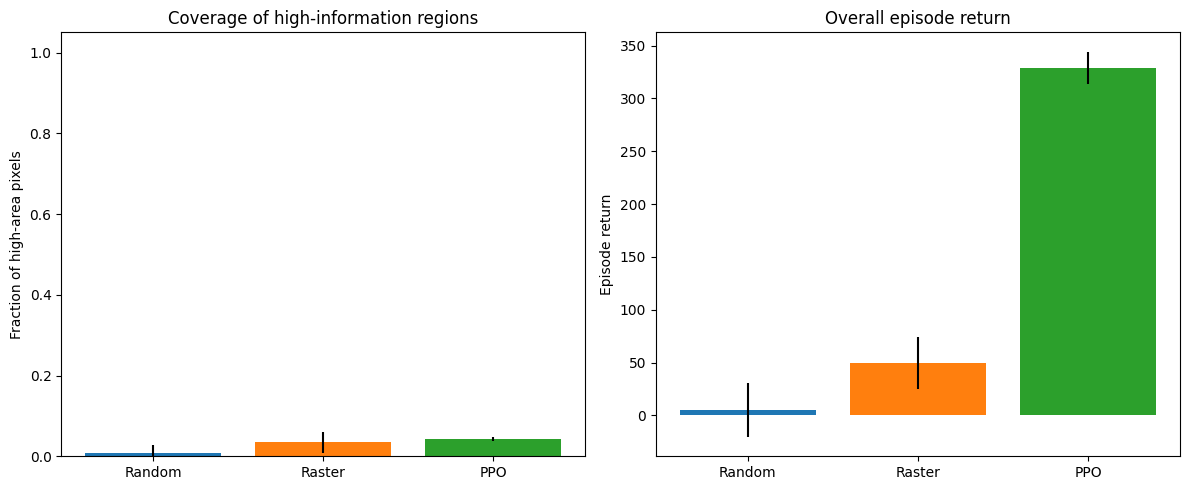

In [ ]:
import matplotlib.pyplot as plt

labels = ["Random", "Raster", "PPO"]

means_cov = [cov_rnd.mean(), cov_ras.mean(), cov_ppo.mean()]
stds_cov  = [cov_rnd.std(),  cov_ras.std(),  cov_ppo.std()]

means_ret = [ret_rnd.mean(), ret_ras.mean(), ret_ppo.mean()]
stds_ret  = [ret_rnd.std(),  ret_ras.std(),  ret_ppo.std()]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Coverage bar plot
ax[0].bar(labels, means_cov, yerr=stds_cov, color=["tab:blue","tab:orange","tab:green"])
ax[0].set_ylim(0, 1.05)
ax[0].set_ylabel("Fraction of high-area pixels")
ax[0].set_title("Coverage of high-information regions")

# Return bar plot
ax[1].bar(labels, means_ret, yerr=stds_ret, color=["tab:blue","tab:orange","tab:green"])
ax[1].set_ylabel("Episode return")
ax[1].set_title("Overall episode return")

plt.tight_layout()
plt.savefig("quantitative_metrics.png", dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# --- helper: compute per-episode fraction of regions discovered ---
def region_discovery_stats(high_mask, traj_dict, min_pixels=20):
    """
    high_mask : 2D bool array (True where loop area is 'high')
    traj_dict : {"Name": [traj_ep0, traj_ep1, ...]}, each traj is list of (y, x)
    min_pixels : ignore tiny noisy components smaller than this
    """
    labeled, num_all = ndimage.label(high_mask)

    # Filter out tiny components
    sizes = ndimage.sum(high_mask, labeled, index=np.arange(1, num_all + 1))
    valid_labels = {i + 1 for i, s in enumerate(sizes) if s >= min_pixels}
    n_regions = len(valid_labels)

    stats = {}
    for name, trajs in traj_dict.items():
        fracs = []
        for path in trajs:          # one path = one episode
            discovered = set()
            for (y, x) in path:
                lab = labeled[y, x]
                if lab in valid_labels:
                    discovered.add(lab)
            fracs.append(len(discovered) / max(1, n_regions))
        fracs = np.array(fracs)
        stats[name] = {
            "mean_frac": float(fracs.mean()),
            "std_frac":  float(fracs.std()),
            "n_regions": n_regions,
        }
    return stats

# --- call it using the trajectories you already have ---
traj_dict = {
    "Random": traj_rnd,
    "Raster": traj_ras,
    "PPO":    traj_ppo,
}

region_stats = region_discovery_stats(viz_env.high_mask, traj_dict)
region_stats


{'Random': {'mean_frac': 0.06666666666666667,
  'std_frac': 0.13333333333333333,
  'n_regions': 3},
 'Raster': {'mean_frac': 0.2333333333333333,
  'std_frac': 0.15275252316519466,
  'n_regions': 3},
 'PPO': {'mean_frac': 0.33333333333333337,
  'std_frac': 5.551115123125783e-17,
  'n_regions': 3}}

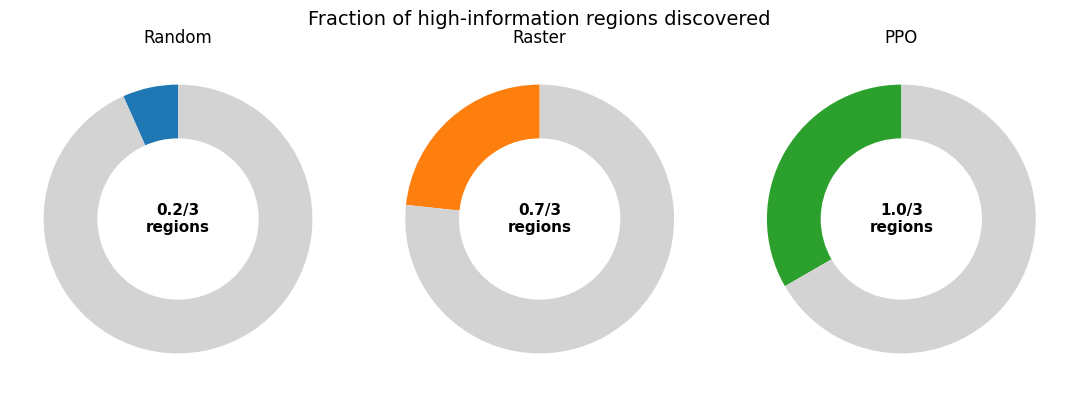

In [ ]:
labels = ["Random", "Raster", "PPO"]
colors = ["tab:blue", "tab:orange", "tab:green"]

means_reg = [region_stats[l]["mean_frac"] for l in labels]
n_regions = region_stats[labels[0]]["n_regions"]   # same for all

fig, axes = plt.subplots(1, 3, figsize=(11, 4))

for ax, name, mean_frac, color in zip(axes, labels, means_reg, colors):
    discovered_mean = mean_frac * n_regions
    sizes = [mean_frac, 1 - mean_frac]

    wedges, _ = ax.pie(
        sizes,
        colors=[color, "lightgray"],
        startangle=90,
        wedgeprops=dict(width=0.4)
    )

    ax.set_title(name, fontsize=12)
    ax.text(
        0, 0,
        f"{discovered_mean:.1f}/{n_regions}\nregions",
        ha="center", va="center",
        fontsize=11, weight="bold"
    )

fig.suptitle("Fraction of high-information regions discovered", fontsize=14)
plt.tight_layout()
fig.savefig("region_discovery_donuts.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def ppo_episode_rewards(env, policy_fn, episodes=5):
    """
    Run 'episodes' episodes with the given policy and
    return a list of reward sequences and their returns.
    """
    all_rewards = []
    returns = []

    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        trunc = False
        ep_rewards = []

        while not (done or trunc):
            a = policy_fn(obs)
            obs, r, done, trunc, info = env.step(a)
            ep_rewards.append(r)

        all_rewards.append(np.array(ep_rewards, dtype=float))
        returns.append(float(np.sum(ep_rewards)))

    return all_rewards, np.array(returns)


# Run a few PPO episodes and collect reward sequences
ppo_rewards_list, ppo_returns = ppo_episode_rewards(env_ppo, ppo_pi, episodes=10)

print("PPO episode returns:", ppo_returns)


PPO episode returns: [315.16655489 338.74199946 353.619077   334.15743005 353.619077
 353.619077   353.619077   338.74199946 334.15743005 338.74199946]


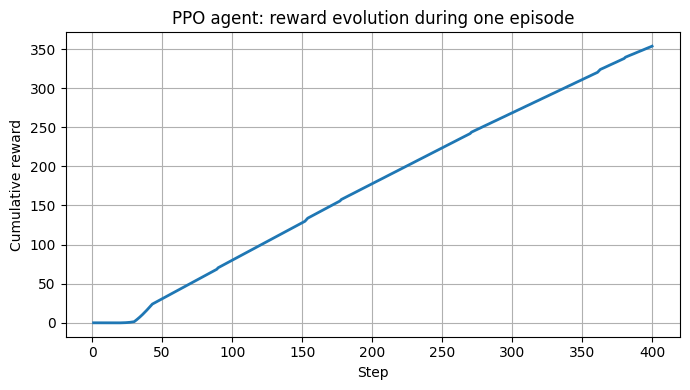

In [ ]:
# Choose the best episode for plotting
best_idx = int(np.argmax(ppo_returns))
best_rewards = ppo_rewards_list[best_idx]

steps = np.arange(1, len(best_rewards) + 1)
cum_rewards = np.cumsum(best_rewards)

plt.figure(figsize=(7,4))
plt.plot(steps, cum_rewards, label="Cumulative reward", linewidth=2)
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.title("PPO agent: reward evolution during one episode")
plt.grid(True)
plt.tight_layout()
plt.savefig("ppo_episode_cumreward.png", dpi=300)
plt.show()


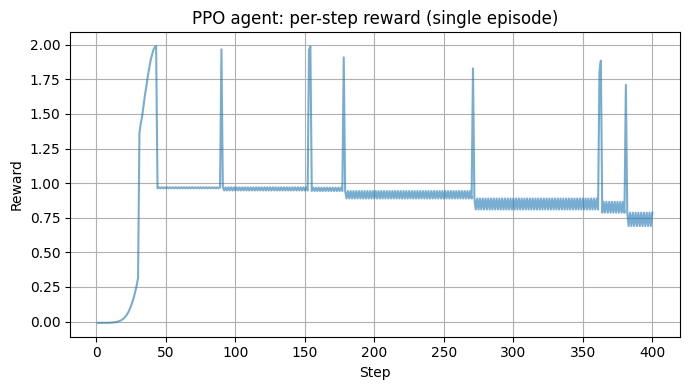

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(steps, best_rewards, alpha=0.6, label="Instantaneous reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("PPO agent: per-step reward (single episode)")
plt.grid(True)
plt.tight_layout()
plt.savefig("ppo_episode_instant_reward.png", dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_episode_rewards(env, policy_fn):
    """
    Run a single episode in `env` using `policy_fn(obs) -> action`
    and return the per-step reward sequence as a NumPy array.
    """
    obs, _ = env.reset()
    done = False
    trunc = False
    rewards = []

    while not (done or trunc):
        a = policy_fn(obs)
        obs, r, done, trunc, info = env.step(a)
        rewards.append(r)

    return np.array(rewards, dtype=float)


In [ ]:
# Run ONE episode for each algorithm
rewards_rand = run_episode_rewards(env_rand_anim, rand_pi)
rewards_ras  = run_episode_rewards(env_ras_anim,  ras_pi)
rewards_ppo  = run_episode_rewards(env_ppo_anim,  ppo_pi)

len(rewards_rand), len(rewards_ras), len(rewards_ppo)

(400, 400, 400)

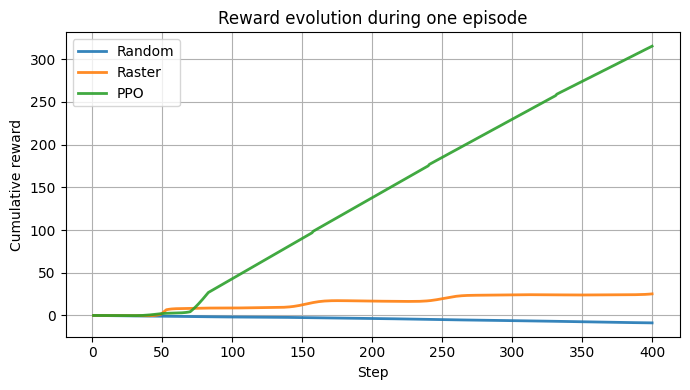

In [ ]:
plt.figure(figsize=(7,4))

for rewards, label, color in [
    (rewards_rand, "Random", "tab:blue"),
    (rewards_ras,  "Raster", "tab:orange"),
    (rewards_ppo,  "PPO",    "tab:green"),
]:
    steps = np.arange(1, len(rewards) + 1)
    cum_rewards = np.cumsum(rewards)
    plt.plot(steps, cum_rewards, label=label, linewidth=2, alpha=0.9, color=color)

plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.title("Reward evolution during one episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("reward_evolution_three_algos.png", dpi=300)
plt.show()


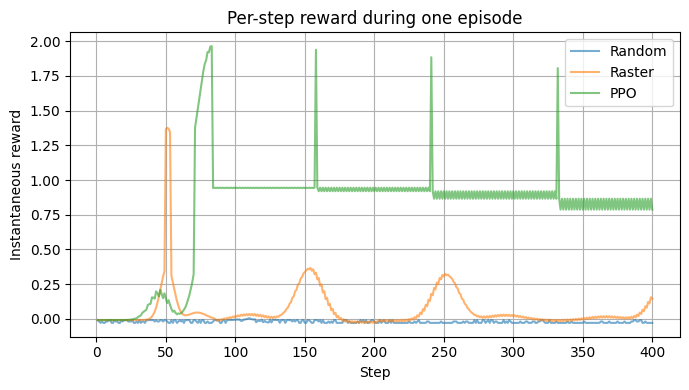

In [ ]:
plt.figure(figsize=(7,4))

for rewards, label, color in [
    (rewards_rand, "Random", "tab:blue"),
    (rewards_ras,  "Raster", "tab:orange"),
    (rewards_ppo,  "PPO",    "tab:green"),
]:
    steps = np.arange(1, len(rewards) + 1)
    plt.plot(steps, rewards, label=label, alpha=0.6, color=color)

plt.xlabel("Step")
plt.ylabel("Instantaneous reward")
plt.title("Per-step reward during one episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("instant_reward_three_algos.png", dpi=300)
plt.show()
